In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from datasets import (load_direct_and_indirect_pairs, 
                      load_costanzo_complexes,
                      load_Y2H_union_25, 
                      load_sys_nb,
                      load_lit_bm_24, 
                      load_I3D_exp_24,
                      load_AlphaFold_RoseTTAFold,
                      load_gi_pcc_values, 
                      load_gi_psn)
from plotting import (COLOR_ALPHAFOLD_ROSETTAFOLD,
                      COLOR_LIT,
                      COLOR_I3D,
                      COLOR_Y2H,
                      COLOR_SYS_NB,
                      COLOR_I3D,
                      COLOR_GI_PSN)

In [2]:
# the ipython matplotlib inline display overrides the rcParams
# that used to be called on the pyplot import but now seems like
# it's called on the first use of inline figures or something 
# problem is in ipython: https://github.com/ipython/ipython/issues/10383
# should be fixed soon: https://github.com/ipython/matplotlib-inline/pull/14
plt.show()
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
# for each complex, count number of direct and indirect pairs observed
complexes = {k: v for k, v in load_costanzo_complexes().items() if len(v) >= 3}
non_redundant_complexes = {}
all_subunits = set()
for complex_name, subunits in sorted(complexes.items(), key=lambda x: len(x[1]), reverse=True):
    if len(subunits.intersection(all_subunits)) == 0:
        non_redundant_complexes[complex_name] = subunits
        all_subunits = all_subunits.union(subunits)
 
df = load_direct_and_indirect_pairs()
data = []
for complex_name, subunits in complexes.items():
    if (df['orf_name_1'].isin(subunits) & df['orf_name_2'].isin(subunits)).sum() == 0:
        continue
    pdb_to_size = {}
    for _i, row in df.loc[df['orf_name_1'].isin(subunits) & df['orf_name_2'].isin(subunits), ['support', 'pdb_size']].drop_duplicates().iterrows():
        for pdb_id, size in zip(row['support'].split(','), row['pdb_size'].split(',')):
            pdb_to_size[pdb_id] = int(size)
    largest_pdb = list(sorted(pdb_to_size.items(), key=lambda x: x[1], reverse=True))[0][0]

    data.append((complex_name,
                largest_pdb,
                 len(subunits),
                 (df['orf_name_1'].isin(subunits) & df['orf_name_2'].isin(subunits) & df['support'].str.contains(largest_pdb) & df['in_contact']).sum(),
                 (df['orf_name_1'].isin(subunits) & df['orf_name_2'].isin(subunits) & df['support'].str.contains(largest_pdb) & ~df['in_contact']).sum(),
                 len(set(df.loc[df['orf_name_1'].isin(subunits) & df['orf_name_2'].isin(subunits)  & df['support'].str.contains(largest_pdb), ['orf_name_1', 'orf_name_2']].values.flatten()))
                
    ))
df = pd.DataFrame(data,
                  columns=['complex',
                           'PDB_ID',
                           'number of different protein subunits',
                           'number of direct interactions',
                           'number of indirect associations',
                           'number of subunits in structure'])
df['full_coverage'] = (df['number of different protein subunits'] == df['number of subunits in structure'])
df['number of direct interactions + indirect associations'] = df['number of direct interactions'] + df['number of indirect associations']


gi = load_gi_psn()
gi['PCC'] = gi.index.map(load_gi_pcc_values()['PCC'])

y2h_union = load_Y2H_union_25(remove_homodimers=True)
y2h_union = y2h_union.loc[y2h_union['Uetz-screen'] | y2h_union['Ito-core'] | y2h_union['CCSB-YI1'], :]
nws = (load_I3D_exp_24(remove_homodimers=True), 
    load_AlphaFold_RoseTTAFold(remove_homodimers=True,
                               restrict_to_high_confidence=True), 
    load_lit_bm_24(remove_homodimers=True), 
    load_sys_nb(remove_homodimers=True), 
    y2h_union,
    gi.loc[gi['PCC'] >= 0.2, :],
    gi.loc[gi['PCC'] >= 0.3, :],
    gi.loc[gi['PCC'] >= 0.5, :],
    )


NOTE: dropping 6 pairs with missing ORF names


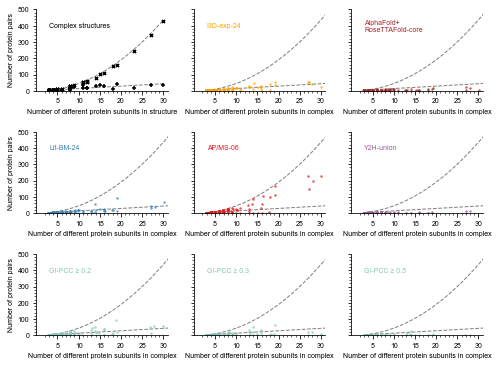

In [4]:

nw_colors = (COLOR_I3D, 
             COLOR_ALPHAFOLD_ROSETTAFOLD,
               COLOR_LIT,
                 COLOR_SYS_NB,
                   COLOR_Y2H,
                   COLOR_GI_PSN,
                   COLOR_GI_PSN,
                   COLOR_GI_PSN)
nw_names = ['I3D-exp-24', 
            'AlphaFold+\nRoseTTAFold-core',
              'Lit-BM-24', 
              'AP/MS-06', 
              'Y2H-union',
              'GI-PCC ≥ 0.2',
              'GI-PCC ≥ 0.3',
              'GI-PCC ≥ 0.5',
              ]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True)
fig.set_size_inches(h=6, w=8)

ax = axs[0, 0]
x = df.loc[df['complex'].isin(non_redundant_complexes) & (df['number of subunits in structure'] >= 3), 'number of subunits in structure'].values
y1 = df.loc[df['complex'].isin(non_redundant_complexes) & (df['number of subunits in structure'] >= 3), 'number of direct interactions + indirect associations'].values
y2 = df.loc[df['complex'].isin(non_redundant_complexes) & (df['number of subunits in structure'] >= 3), 'number of direct interactions'].values
ax.plot(range(3, 31), [(x**2 - x) / 2 for x in range(3, 31)], '--', color='grey', linewidth=1, zorder=-1)
intercept, slope = sm.OLS(y2, sm.add_constant(x)).fit().params
ax.plot(range(3, 31), [intercept + slope * x for x in range(3, 31)], '--', color='grey', linewidth=1, zorder=-1)
ax.scatter(x=x,
            y=y1,
            color='black',
            marker='x',
            s=10,
)
ax.scatter(x=x,
                y=y2,
                color='black',
                marker='+',
                s=10,
)
ax.text(s='Complex structures', x=3, y=400, ha='left', va='center', color='black')

def add_jitter(x):
    return x + np.random.randn() * 0.1

for nw, nw_name, color, ax in zip(nws, nw_names, nw_colors, axs.flatten()[1:]):
    xy = [(len(subunits), (nw['orf_name_a'].isin(subunits) & nw['orf_name_b'].isin(subunits)).sum()) for subunits in non_redundant_complexes.values()]
    xy = [(x, y) for x, y in xy if y > 0]
    ax.scatter(x=[add_jitter(x) for x, _y in xy],
               y=[y for _x, y in xy],
               color=color,
               linewidths=0,
               s=6,
               alpha=0.75)
    ax.plot(range(3, 81), [(x**2 - x) / 2 for x in range(3, 81)], '--', color='grey', linewidth=1, zorder=-1)
    intercept, slope = sm.OLS(y2, sm.add_constant(x)).fit().params
    ax.plot(range(3, 81), [intercept + slope * x for x in range(3, 81)], '--', color='grey', linewidth=1, zorder=-1)
    ax.text(s=nw_name, x=3, y=400, ha='left', va='center', color=color)
for ax in axs.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(range(5, 31, 5))
    ax.set_xticks(range(2, 31), minor=True)
    ax.set_ylim(0, 500)
    ax.set_xlim(0, 31)
    ax.set_yticks(range(0, 500, 20), minor=True)

for ax in axs[:, 0]:
    ax.set_ylabel('Number of protein pairs')
axs[0, 0].set_xlabel('Number of different protein subunits in structure')
for ax in axs.flatten()[1:]:
    ax.set_xlabel('Number of different protein subunits in complex')
plt.subplots_adjust(hspace=0.5)
fig.savefig('../figures/complex-size-vs-number-PPIs_all-datasets_Y2H-union_gi-psn.pdf',
            bbox_inches='tight')